#     Understanding Convolutions by hand vs. TensorFlow 
### Do you think we can match by hand what TensorFlow yields? You bet!

* [1: Purpose](#Code_Objective_1)
* [2: Background](#Code_Objective_2)
* [3: Import Libraries](#Code_Objective_3)
* [4: Get Input Volume](#Code_Objective_4)
* [5: Get Filter](#Code_Objective_5)
* [6: Zero Pad](#Code_Objective_6)
* [7: Set Stride, S](#Code_Objective_7)
* [8: Manual conv2d](#Code_Objective_8)
* [9: TensorFlow Conv2d](#Code_Objective_9)
* [10: Export Results](#Code_Objective_10)
* [11: References](#Code_Objective_11)

# 1. Purpose<a class="anchor" id="Code_Objective_1"></a>
TensorFlow and various other open source libraries for machine learning like Scipy, provide these nice built in functions for performing convolutions. However, as nice as these functions are, it is worth opening the hood to discover the power behind the code. In my opinion, without the convolutional layer, computer vision would be as blind as a bat. So I hope you enjoy this article because we will dig into the convolutions in convolutional layers and see the big picture together.

# 2. Background<a class="anchor" id="Code_Objective_2"></a>
Convolutions are not new with deep learning tasks in computer vision. They are simply a technique used in image processing. In image processing, a convolution operation can be performed between a kernel and an input image. The convolution operation is the process of summing each element of the input image with its local neighbors, weighted by the kernel.[1](#Ref_1)
Kernels can come in all shapes and sizes. These kernels make up filters, which are a parameters used in convolutional layers. For this article, I will stick with a common filter based on Edge Detection[1](#Ref_1):

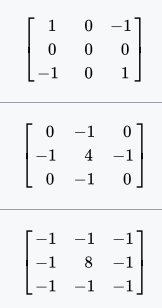


*<center>Example of edge detection kernels[1](#Ref_1)</center>*



# 3. Import Libraries<a class="anchor" id="Code_Objective_3"></a>

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from skimage.exposure import rescale_intensity

# 4. Get Input Volume<a class="anchor" id="Code_Objective_4"></a>

In [2]:
def get_input(use_image=False,random_seed=1,w=5,h=5,d=3):
    global x,W,H,D
    if use_image==True:
        path_image="/Users/h4/desktop/image_1.jpg"
        img=cv2.imread(path_image)
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(RGB_img, cv2.COLOR_BGR2GRAY)
        RGB_img=RGB_img[0:400,0:400,:] #cropped to reindeer for example
        display(RGB_img.shape) #display shape
        plt.imshow(RGB_img) #show cropped reindeer
        W=RGB_img.shape[0] #width of input array
        H=RGB_img.shape[1] #height of input array
        D=RGB_img.shape[2] #depth of input array
        x=RGB_img
        display(x[:,:,0]) # show input array channel 0
        display(x[:,:,1]) # show input array channel 0
        display(x[:,:,2]) # show input array channel 0
    else:
        # Input Array
        W=w #width of input array
        H=h #height of input array
        D=d #depth of input array
        # random x volume for example
        np.random.seed(random_seed) #for reproducibility
        x=np.random.rand(W,H,D)*4 #up to 4 random numbers 
        x=x.astype(int)
        display(x[:,:,0])
        display(x[:,:,1])
        display(x[:,:,2])
        display(x.shape)

In [3]:
get_input(False)

array([[1, 1, 0, 2, 0],
       [2, 0, 3, 3, 0],
       [0, 2, 2, 3, 1],
       [1, 1, 2, 1, 0],
       [0, 1, 2, 2, 0]])

array([[2, 0, 1, 1, 3],
       [1, 0, 1, 3, 0],
       [1, 2, 3, 3, 3],
       [3, 0, 0, 0, 2],
       [1, 0, 2, 3, 3]])

array([[0, 0, 1, 2, 0],
       [2, 3, 2, 0, 3],
       [3, 1, 0, 2, 0],
       [1, 0, 1, 2, 2],
       [2, 2, 3, 0, 1]])

(5, 5, 3)

# 5. Get Filter<a class="anchor" id="Code_Objective_5"></a>
**Edge detection kernels**


https://en.wikipedia.org/wiki/Kernel_(image_processing)

In [4]:
def get_filter():
    global w
    # Kernel
    Wk=3
    Hk=3
    Dk=3
    w=np.zeros(shape=(Wk,Hk,Dk)).astype(int) #initialize 3x3x3 kernel
    w[:,:,0]=np.array(([1,0,-1],[0,0,0],[-1,0,1]),dtype='int')
    display(w[:,:,0]) # Edge detection
    w[:,:,1]=np.array(([0,-1,0],[-1,4,-1],[0,-1,0]),dtype='int')
    display(w[:,:,1]) # Edge detection
    w[:,:,2]=np.array(([-1,-1,-1],[-1,8,-1],[-1,-1,-1]),dtype='int')
    display(w[:,:,2])
    display(w.shape)

In [5]:
get_filter()

array([[ 1,  0, -1],
       [ 0,  0,  0],
       [-1,  0,  1]])

array([[ 0, -1,  0],
       [-1,  4, -1],
       [ 0, -1,  0]])

array([[-1, -1, -1],
       [-1,  8, -1],
       [-1, -1, -1]])

(3, 3, 3)

# 6. Zero Pad<a class="anchor" id="Code_Objective_6"></a>

In [6]:
P=1 #zero padding

In [7]:
def padded(A,ref):
    results=np.zeros(shape=(ref.shape))
    s=(ref.shape[0]-A.shape[0])//2
    print(s)
    results[s:A.shape[0]+s,s:A.shape[1]+s,:A.shape[2]]=A
    return results

In [8]:
x=padded(x,np.zeros(shape=(x.shape[0]+2*P,x.shape[1]+2*P,x.shape[2])))

1


In [9]:
x[:,:,0].shape

(7, 7)

# 7. Set Stride, S<a class="anchor" id="Code_Objective_7"></a>

In [10]:
S=2

# 8. Manual conv2d <a class="anchor" id="Code_Objective_8"></a>

In [11]:
def conv2d_pad_str(x,w0,S=2,b0=np.ones(shape=(1))):
    if len(x.shape)>2:
        xc=x.shape[2]
    else:
        xc=1
    xl=x.shape[1] #input volume length
    xw=x.shape[0] #input volume width
    fl=w0.shape[1] #filter length
    fw=w0.shape[0] #filter width
    ol=(xl-fl)//S+1 #output volume length
    ow=(xw-fw)//S+1 #output volume width
    if len(x.shape)>2: #
        output=np.zeros(shape=(ol,ow,1))
        output[:,:,0]=output[:,:,0]+b0
    else:
        output=np.zeros(shape=(ol,ow))
        output[:,:]=output[:,:]+b0

    for c in range(0,xc):
        cj=0
        for j in range(0,xl+S,S):
            ci=0
            for i in range(0,xw+S,S):
                if i>xw-fw: #reached the end of the row, breaks to next row
                    break
                if j>xl-fl: #reached the end of the column, breaks to next column
                    break
                if len(x.shape)>2:
                    output_ji=np.sum(x[:,:,c][j:j+fl,i:i+fw]*w0[:,:,c])
                else:
                    output_ji=np.sum(x[:,:][j:j+fl,i:i+fl]*w0[:,:])
                if len(x.shape)>2:
                    output[cj,ci,0]+=output_ji
                else:
                    output[cj,ci]+=output_ji
                ci+=1
            cj+=1
    return output

In [12]:
bias=np.ones(shape=(1))
output=conv2d_pad_str(x,w,S,bias)
output[:,:,0]

array([[ 3.,  7.,  4.],
       [17., -7.,  1.],
       [14., 25., 13.]])

In [13]:
def rescale_int(A):
    A= rescale_intensity(A, in_range=(0, 255))
    A = (A * 255).astype("uint8")
    plt.imshow(A)
    display(A)
    display(A.shape)

array([[ 3,  7,  4],
       [17,  0,  1],
       [14, 25, 13]], dtype=uint8)

(3, 3)

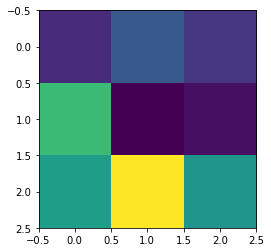

In [14]:
rescale_int(output[:,:,0])

# 9. TensorFlow Conv2d<a class="anchor" id="Code_Objective_9"></a>

In [15]:
def tensorflow_conv(x=x,w=w,bias=bias,S=S):
    global tf_output
    import tensorflow as tf
    x=np.asarray(x).astype(np.float32)
    x_tf=tf.constant(np.expand_dims(x,axis=0),dtype=tf.float32)
    f_tf=tf.constant(np.expand_dims(w,axis=0),dtype=tf.float32)
    x_tf=tf.reshape(x_tf,shape=(1,x.shape[0],x.shape[1],x.shape[2]))
    f_tf=tf.reshape(f_tf,shape=(w.shape[0],w.shape[1],w.shape[2],1))
    b_tf=tf.constant(bias,dtype=tf.float32)
    conv_tf=tf.nn.conv2d(x_tf,f_tf,strides=[1,S,S,1],padding='VALID')
    conv_tf=tf.nn.bias_add(conv_tf,b_tf)[0,:,:,0]
    tf_output=conv_tf.numpy()
    display(tf_output)
    display(tf_output.shape)

In [16]:
tensorflow_conv(S=1)

array([[  3.,  -9.,   7.,   5.,   4.],
       [ 12.,  15.,   5.,  -3.,  11.],
       [ 17.,   1.,  -7.,  11.,   1.],
       [ 10., -17.,  -6.,  -1.,  15.],
       [ 14.,   6.,  25.,   1.,  13.]], dtype=float32)

(5, 5)

array([[ 3,  0,  7,  5,  4],
       [12, 15,  5,  0, 11],
       [17,  1,  0, 11,  1],
       [10,  0,  0,  0, 15],
       [14,  6, 25,  1, 13]], dtype=uint8)

(5, 5)

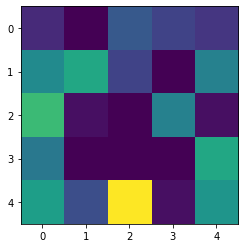

In [17]:
rescale_int(tf_output[:,:])

# 10. Export Results<a class="anchor" id="Code_Objective_10"></a>

In [18]:
writer = pd.ExcelWriter('conv2d_custom.xlsx', engine='xlsxwriter')

In [19]:
x_0=pd.DataFrame(x[:,:,0])
x_1=pd.DataFrame(x[:,:,1])
x_2=pd.DataFrame(x[:,:,2])

w_0=pd.DataFrame(w[:,:,0])
w_1=pd.DataFrame(w[:,:,1])
w_2=pd.DataFrame(w[:,:,2])

b_0=pd.DataFrame(bias)

o_0=pd.DataFrame(output[:,:,0])

In [20]:
x_0.to_excel(writer,sheet_name='x_0',index=False)
x_1.to_excel(writer,sheet_name='x_1',index=False)
x_2.to_excel(writer,sheet_name='x_2',index=False)

w_0.to_excel(writer,sheet_name='w_0',index=False)
w_1.to_excel(writer,sheet_name='w_1',index=False)
w_2.to_excel(writer,sheet_name='w_2',index=False)
b_0.to_excel(writer,sheet_name='b_0',index=False)
o_0.to_excel(writer,sheet_name='o_0',index=False)
writer.save()

# 11. References<a class="anchor" id="Code_Objective_11"></a>
1. Kernel (image processing)[https://en.wikipedia.org/wiki/Kernel_(image_processing)] <a class="anchor" id="Ref_1"></a>  

2. tf.nn.conv2d [https://www.tensorflow.org/api_docs/python/tf/nn/conv2d] <a class="anchor" id="Ref_2"></a>   

3.  Python. a) Travis E. Oliphant. Python for Scientific Computing, Computing in Science & Engineering, 9, 10–20 (2007) b) K. Jarrod Millman and Michael Aivazis. Python for Scientists and Engineers, Computing in Science & Engineering, 13, 9–12 (2011) <a class="anchor" id="Ref_3"></a>    

4. TensorFlow.  Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo, Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow, Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,Yuan Yu, and Xiaoqiang Zheng.  TensorFlow: Large-scale machine learning on heterogeneous systems, 2015. Software available from tensorflow.org. <a class="anchor" id="Ref_4"></a>   

5.  SciPy. Pauli Virtanen, Ralf Gommers, Travis E. Oliphant, Matt Haberland, Tyler Reddy, David Cournapeau, Evgeni Burovski, Pearu Peterson, Warren Weckesser, Jonathan Bright, Stéfan J. van der Walt, Matthew Brett, Joshua Wilson, K. Jarrod Millman, Nikolay Mayorov, Andrew R. J. Nelson, Eric Jones, Robert Kern, Eric Larson, CJ Carey, İlhan Polat, Yu Feng, Eric W. Moore, Jake VanderPlas, Denis Laxalde, Josef Perktold, Robert Cimrman, Ian Henriksen, E.A. Quintero, Charles R Harris, Anne M. Archibald, Antônio H. Ribeiro, Fabian Pedregosa, Paul van Mulbregt, and SciPy 1.0 Contributors. (2019) SciPy 1.0–Fundamental Algorithms for Scientific Computing in Python. preprint arXiv:1907.10121 <a class="anchor" id="Ref_5"></a>   

6.  NumPy. a) Travis E. Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006). b) Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22–30 (2011) <a class="anchor" id="Ref_6"></a>   

7.  IPython. a) Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21–29 (2007) <a class="anchor" id="Ref_7"></a>   

8.  Matplotlib. J. D. Hunter, “Matplotlib: A 2D Graphics Environment”, Computing in Science & Engineering, vol. 9, no. 3, pp. 90–95, 2007. <a class="anchor" id="Ref_8"></a>   

9.  Pandas. Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51–56 (2010) <a class="anchor" id="Ref_9"></a>   

10. Scikit-Learn. Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825–2830 (2011) <a class="anchor" id="Ref_10"></a>   

11.  Scikit-Image. Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python, PeerJ 2:e453 (2014) <a class="anchor" id="Ref_11"></a> 